In [2]:
from __future__ import division
from __future__ import print_function
import numpy as np
from pandas import Series, DataFrame
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_1samp

import datetime
plt.rc('figure', figsize=(16, 10))
from IPython.display import Image

# FINM8006 Advanced Investment 

## Event Studies and Information
---
Qiaoqiao Zhu   
Australian National University

### Abnormal Returns of Events

Returns with information arrival. 

We've seen market efficiency tests try to test for following in time-series and cross-section:

$$ E\underbrace{(R_{i,t+1}-E_{t}(R_{i,t+1}|I_{t}))}_{\text{Abnormal Return}}=0 $$
If we know the exact event, then we can calculate the valuation effect

$$ R_{i,t+1}-E_{t}(R_{i,t+1}|I_{t}) =(R_{i,t+1}|event)-E_{t}(R_{i,t+1}|\text{no event}) $$

that is, the abnormal performance associated with an event.

Many information event on the market:
 * Earnings release
 * Dividend Payments
 * M&A
 * Insider trades
 * etc.

In [138]:
dsf = pd.read_pickle('../datalib/dsf20112013.pickle')
dsf['date'] = pd.to_datetime(dsf['date'])
dsf = dsf.groupby(['permco', 'date']).last().reset_index()
dsf.head(3)

,permco,date,ret
0,5.0,2011-01-03,0.014778
1,5.0,2011-01-04,0.004854
2,5.0,2011-01-05,-0.004831


In [139]:
dmkt = pd.read_pickle('../datalib/dmkt20112013.pickle')
dmkt['date'] = pd.to_datetime(dmkt['date'])
dsf = dsf.merge(dmkt, on='date', how='inner')
dsf['exret'] = dsf.ret - dsf.vwretd
dsf.head(3)

,permco,date,ret,vwretd,exret
0,5.0,2011-01-03,0.014778,0.011205,0.003574
1,7.0,2011-01-03,0.021732,0.011205,0.010528
2,33.0,2011-01-03,-0.005180,0.011205,-0.016385


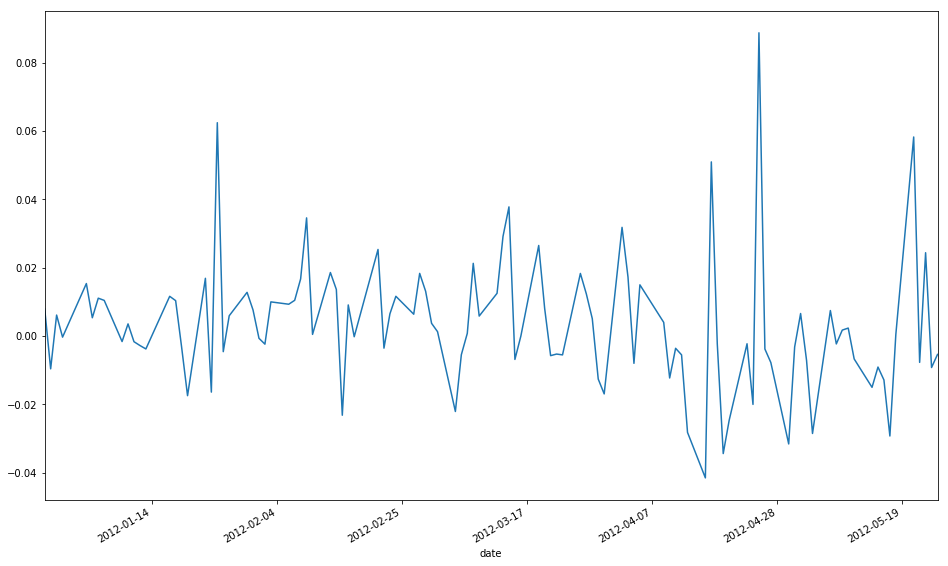

In [6]:
# AAPL PERMCO = 7
# April 25, 2012 earning release
aapl = dsf.loc[dsf.permco==7].reset_index().drop('index', axis=1)
aapl.loc[(aapl.date>='2011-12-25') & (aapl.date<='2012-05-25')].set_index('date')['ret'].plot()

Q: What represent the new information?

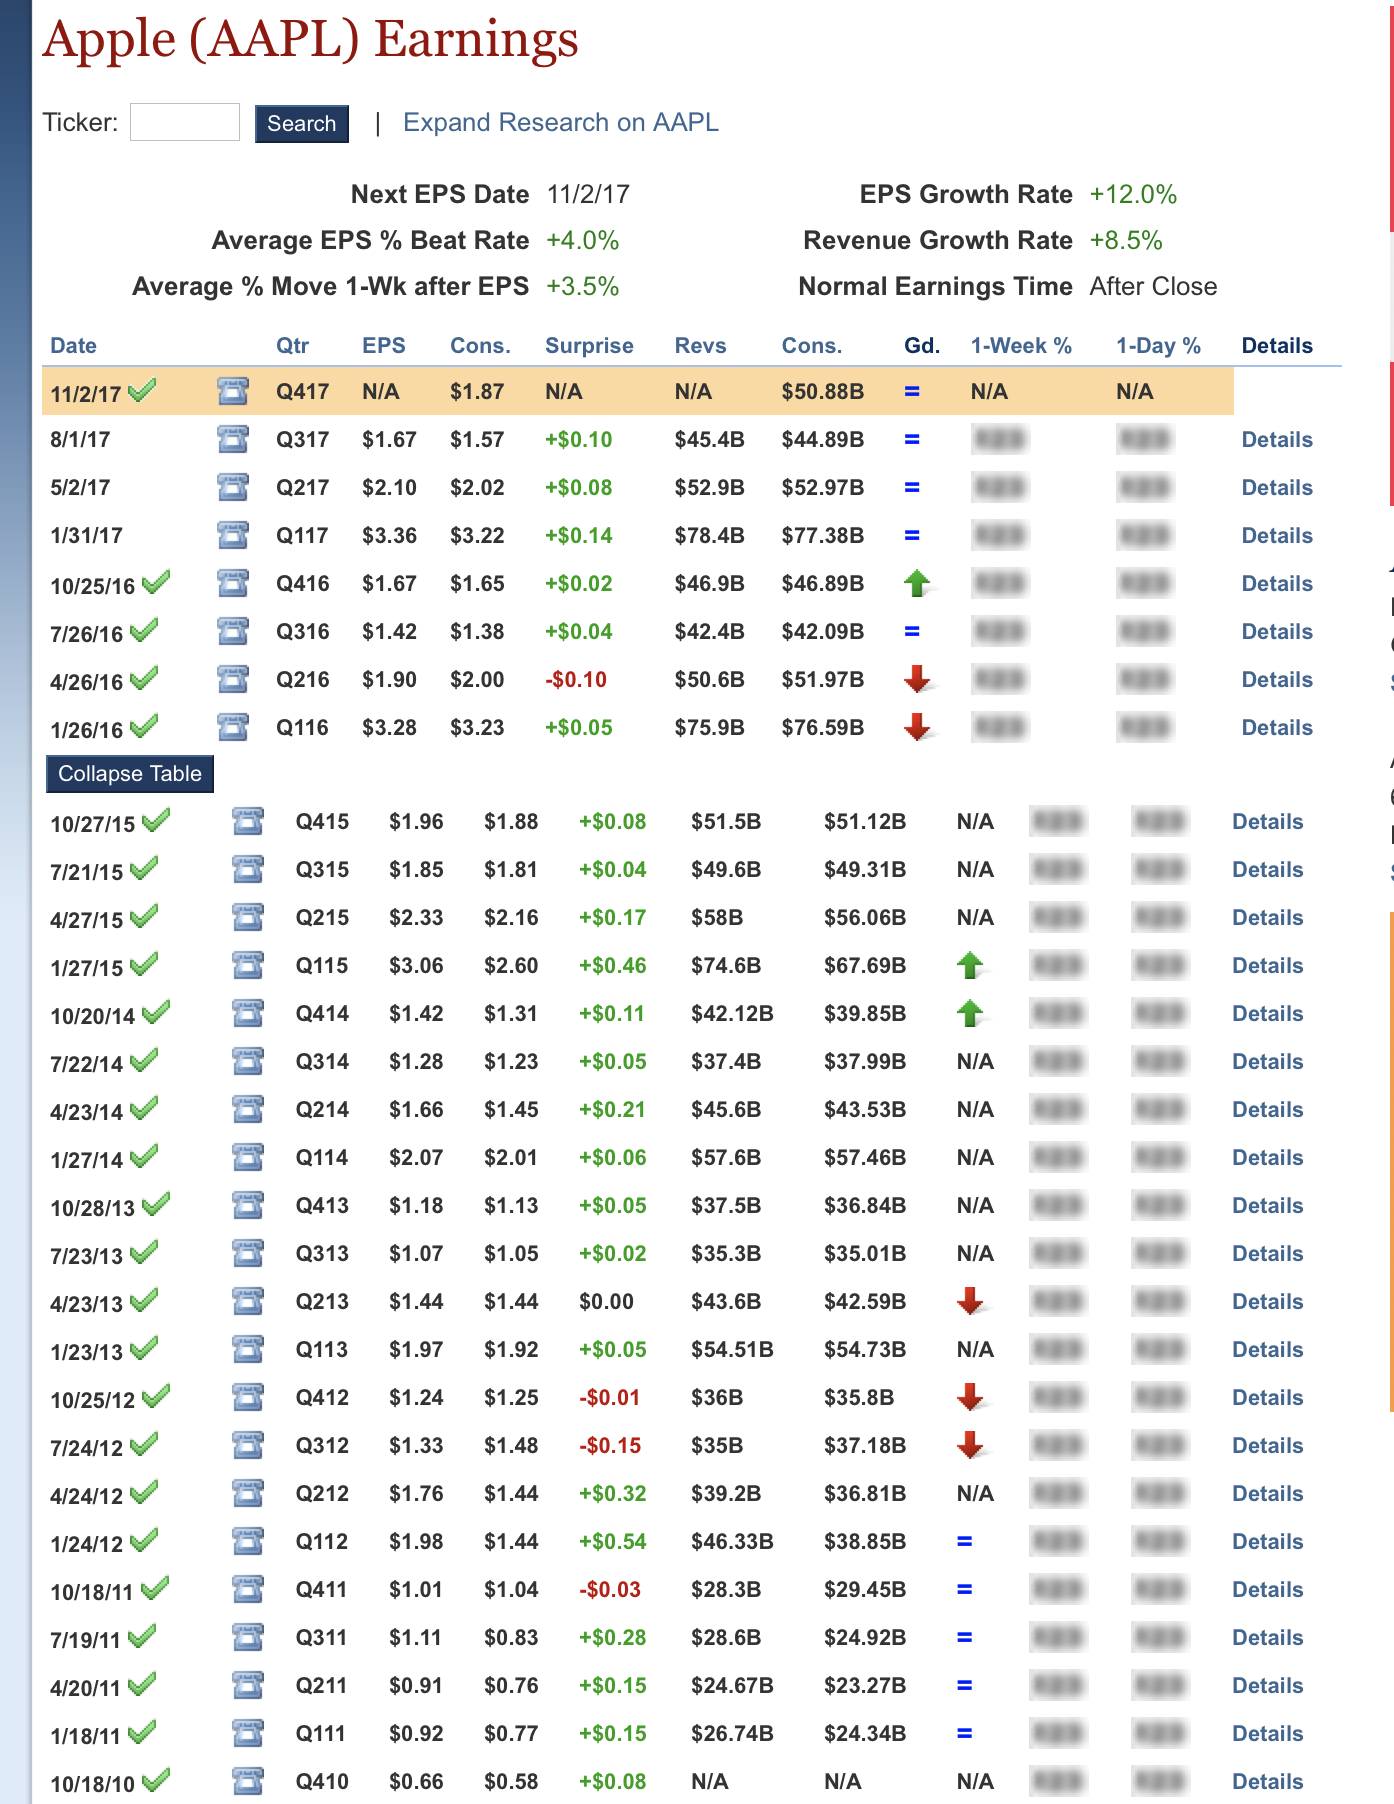

In [120]:
Image('../img/aapl_earnings.PNG')

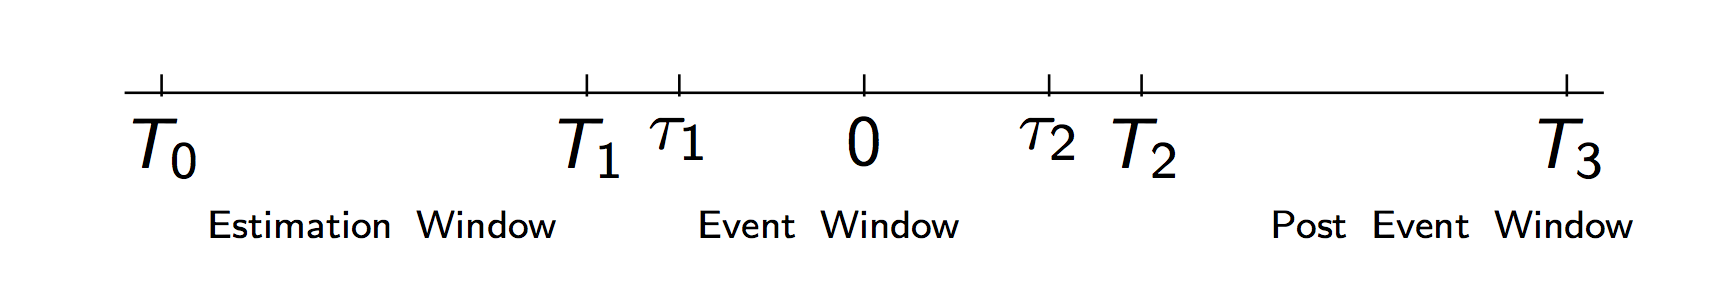

In [140]:
Image("../img/event_timeline.png")

### Event Timeline


* $(T_{0}, T_{1})$ is the estimation window, used to find the parameters of the model.
* $(\tau_{1}, \tau_{2})$ is the event window, time $0$ is the event date. It's good practice to leave some time between estimation and event window
* $(T_{2}, T_{3})$ is the post event window.

### Measuring Normal Returns
estimate (mostly) in estimation windows
* Market model
$$R_{i,t}=\alpha_{i}+\beta_{i}R_{Mt}+\varepsilon_{it},  \text{ where } E[\varepsilon_{it}]=0 \text{ and } Var(\varepsilon_{it})=\sigma^{2}_{\varepsilon i}$$

* Constant mean return model ($\beta=0$)
$$ R_{i,t}=\mu_{i}+\xi_{i,t},  \text{ where } E[\xi_{it}]=0 \text{ and } Var(\xi_{it})=\sigma^{2}_{\xi i}$$

* Market Adjusted Returns. ($\beta=1$). Measure abnormal return as
$$ R_{i,t}-R_{M,t}  $$ Use when you have diversified stocks.

* Other factor models

#### Abnormal Returns
For $\tau\in (\tau_{1}, \tau_{2})$
$$AR_{i,\tau}= R_{i,\tau}-\hat{NR_{i,\tau}} $$

* Market Model $AR_{i,\tau}= R_{i,\tau}-\hat{\alpha}_{i}-\hat{\beta}_{i}R_{M\tau} $
* Constant Mean Model $AR_{i,\tau}= R_{i,\tau}-\bar R_{i,t} $
* Market Adjusted Model $AR_{i,\tau}= R_{i,\tau}- R_{M,\tau} $


For example, earnings announcement response using market model. Estimation window [-200, -15]

In [7]:
# 2012,-01-24, 2012-04-25
et = aapl[aapl.date=='2012-01-24'].index.tolist()[0]
print(et)
T0 = et - 200
T1 = et - 15
data = aapl.loc[T0:T1]
data.head(3)

266


,permco,date,ret,vwretd,exret
66,7.0,2011-04-07,0.000118,-0.002255,0.002373
67,7.0,2011-04-08,-0.008933,-0.003388,-0.005545
68,7.0,2011-04-11,-0.012714,-0.004720,-0.007995


In [8]:
fit = smf.ols('ret ~ vwretd', data=data).fit()
beta = fit.params

In [9]:
tao0 = et - 1
tao1 = et + 1
event = aapl.loc[tao0:tao1]
nr = beta[1] * event['vwretd'] + beta[0]
abr = event.ret - nr
abr

265    0.014438
266   -0.017128
267    0.053988
dtype: float64

#### Distribution of Abnormal Returns

Under the null hypothesis that the event has no effect on stock prices, the abnormal returns will be jointly normally distributed with

$$ E[AR_{i,\tau}]=0  \text{ and } Var[AR_{i,\tau}]\approx \hat\sigma^{2}_{\varepsilon i} $$

if $L_{1}=T_{1}-T_{0} $ is large.

In [11]:
fit.resid.var() 

0.00015323499037114683

### CAR

Abnormal returns must be aggregated to make overall inferences regarding the event of interest
$$ CAR_{i}(\tau_{1},\tau_{2})=\sum_{\tau=\tau_{1}}^{\tau_{2}} AR_{i,\tau} $$

Let $ Var[AR_{i,\tau}]\equiv V_{i}$ \text{and} $\tau_{2}-\tau_{1}+1=k$, then 
$$Var(CAR_{i})=\sigma^{2}_{i}(\tau_{1},\tau_{2})=k\cdot V_{i} $$
Under the null of no abnormal performance: 
$$CAR_{i}(\tau_{1},\tau_{2})\sim N(0, \hat\sigma^{2}_{i}(\tau_{1},\tau_{2}))$$

In [12]:
car = abr.sum()
print("Cumulative Abnormal Return:", car)
sd = np.sqrt(fit.resid.var() * 3)
tstat = car/sd
print("T-stats:", tstat)

Cumulative Abnormal Return: 0.0512975910269
T-stats: 2.39252988228


Alternatively, using market adjusted return approach

In [13]:
exsum = event.exret.sum()
exsd = data.exret.std() * np.sqrt(3)
print('CAR and T-stat:', exsum, exsum/exsd)

CAR and T-stat: 0.0522196805566 2.2716948905


You will notice that the results you get using different approach are very similar. 

Brown and Warner (1985): In daily data and short window, the simple mean returns model often
yields results similar to those of more sophisticated models because the
variance of abnormal returns is not reduced much by choosing a more sophisticated model.

### CAAR: Aggregating across events

Sometimes, we are interested in the effect of an event type (e.g. earnings announcement, SEO). We can then find the average effect by aggregating across $N$ firms-events.
Given the assumption that $N$ events are independent, the cumulative average abnormal return (CAAR) is

$$ CAAR(\tau_{1},\tau_{2})= \frac{1}{N}\sum_{i=1}^{N} CAR_{i} =\sum_{\tau=\tau_{1}}^{\tau_{2}} \frac{1}{N}\sum_{i=1}^{N} AR_{i,\tau} $$

Let's see an example of announcing dividend increase of 15% and more. 

In [14]:
div = pd.read_pickle('../datalib/dist.pickle')
div['dclrdt'] = pd.to_datetime(div['dclrdt'])
div = div.loc[div.dclrdt.dt.year==2012]
div = div.loc[(div.divamt-div.lagdiv)/div.lagdiv>=0.15]
div = div.groupby(['permco', 'dclrdt']).last().reset_index()
print(div.shape)
div.head(3)

(647, 4)


,permco,dclrdt,divamt,lagdiv
0,116.0,2012-05-01,0.460,0.3611
1,153.0,2012-09-27,0.080,0.0400
2,176.0,2012-08-14,0.045,0.0350


In [15]:
dsfdiv = dsf.merge(div[['permco', 'dclrdt']], left_on=['permco', 'date'], right_on=['permco', 'dclrdt'], how='left')
dsfdiv.head()

,permco,date,ret,vwretd,exret,dclrdt
0,5.0,2011-01-03,0.014778,0.011205,0.003574,NaT
1,7.0,2011-01-03,0.021732,0.011205,0.010528,NaT
2,33.0,2011-01-03,-0.005180,0.011205,-0.016385,NaT
3,37.0,2011-01-03,0.025556,0.011205,0.014351,NaT
4,59.0,2011-01-03,0.007156,0.011205,-0.004049,NaT


simple market adjusted cumulative abnormal return 

In [16]:
dsfdiv['car'] = dsfdiv.rolling(window=3, center=True, min_periods=3)['exret'].sum()
dsfdiv['ct'] = dsfdiv.rolling(window=3, center=True, min_periods=3)['exret'].count()
divdclr = dsfdiv.loc[dsfdiv.dclrdt.notnull()]
divdclr = divdclr.loc[divdclr.ct==3]
divdclr.head(3)

,permco,date,ret,vwretd,exret,dclrdt,car,ct
1440537,50852.0,2012-01-03,0.001693,0.016152,-0.014458,2012-01-03,0.088104,3.0
1446993,53414.0,2012-01-04,-0.000097,-0.000447,0.000350,2012-01-04,0.048970,3.0
1468620,50838.0,2012-01-10,0.006390,0.010420,-0.004030,2012-01-10,-0.015490,3.0


In [17]:
print('CAAR:', divdclr.car.mean())
ttest_1samp(divdclr.car, 0)

CAAR: 0.00730928336535


Ttest_1sampResult(statistic=3.8056969801130802, pvalue=0.00015527055928510024)

On average, announcing dividend increase increases return by 0.7% and is highly significant. That is, dividend is a positive signal. 

### Long Run Event Study

Much more complicated. Potential issues
* Getting the benchmark index wrong: New Listings, index rebalanced
* Positive skewness
* Asset Pricing model more important: small mistakes lead to big differences

#### BHAR 

$$ BHAR=\prod_{t\in\tau} (1+R_{it}) - \prod_{t\in\tau}  (1+E (R_{it})) $$

BHAR vs CAR
* CAR does not consider compounding
* CAR uses arithmetic rather than geometric average.
* For BHAR close to zero (and below), CAR is higher; For large BHAR, CAR is much lower.

## The information process

How is the information of individual traders incorporated into price? How the price react to public information?

### CARA Individual Demand

Agent $i$ solves
$$ \max_{x_{i}} E_{i,t}[-exp(-a_{i}W_{i,t+1})]$$, by normality, we can use lognormal proporty
$$
\begin{align} \max E_{i,t}(W_{i,t+1})-\frac{1}{2}a_{i}VAR_{i,t}(W_{i,t+1}) \\
\text{s.t} \qquad W_{i,t+1}=(1+r_{f})(W_{i,t}-p_{t}x_{i})+p_{t+1}x_{i}
\end{align}
$$
where $x_{i}$ is the number of shares bought of the risky asset.


$$\max_{x_{i}} E_{i,t}[p_{t+1}-(1+r_{f})p_{t}]x_{i}-\frac{1}{2}a_{i}x^{2}_{i}VAR_{i,t}(p_{i,t+1}) $$
and the FOC is
$$ E_{i,t}[p_{t+1}-(1+r_{f})p_{t}]=a_{i}x_{i}VAR_{i,t}(p_{i,t+1}) $$

$$ \Rightarrow x_{i}=\frac{E_{i,t}[p_{t+1}]-(1+r_{f})p_{t}}{a_{i}VAR_{i,t}(p_{i,t+1})} $$

which is the myopic formula for the CARA model. Asset demand is linear in the
price and independent of household wealth.

#### Private signal

Let's assume that the individual observed a signal $\tilde{y_{i}}$ of the true price $p_{t+1}$.
$$ \tilde{y_{i}}=p_{t+1}+\varepsilon_{i}, \qquad \varepsilon_{i} \sim N(0,\sigma^{2}_{i}) $$
if we run regression
$$ p_{t+1}=\bar{m}+\beta (\tilde{y_{i}}-\bar{m} )+\nu_{i}$$
where $\bar{m}=E(\tilde{y_{i}})=E(p_{t+1})$ is the unconditional mean.
$$ \beta= \frac{cov(p_{t+1},\tilde{y_{i}} )}{VAR(\tilde{y_{i}})}=\frac{\sigma^{2}}{\sigma^{2}+\sigma^{2}_{i}}=\rho_{i} $$
where $\sigma^{2}$ is the unconditional variance of price. $\beta$ measures how much true price is explained by signal.

#### Competitive equilibrium

In competitive equilibrium, $E_{i,t}[p_{t+1}]=E_{i,t}[p_{t+1}|y_{i}] $.

$$ E_{i,t}[p_{t+1}|y_{i}]=\bar{m}+\rho_{i}(y_{i}-\bar{m}) $$
$$ VAR_{i,t}[p_{t+1}|y_{i}]=\sigma^{2}_{\nu}=(1-\rho_{i}^{2})\sigma^{2}-\rho_{i}^{2}\sigma^{2}_{i}=(1-\rho_{i})\sigma^{2} $$

The above uses $ var(\nu) = var ( (1-\beta)P_{t+1} - \beta \varepsilon_{i}) $

Therefore the demand for the risky asset is
$$ x_{i}=\frac{E_{i,t}[p_{t+1}]-(1+r_{f})p_{t}}{a_{i}VAR_{i,t}(p_{i,t+1})}=\frac{\bar{m}+\rho_{i}(y_{i}-\bar{m})-(1+r_{f})p_{t}}{a_{i}(1-\rho_{i})\sigma^{2}}$$

investor trades more aggressively if information is more precise.


we can solve for equilibrium price by aggregating demand and set it to $X^{S}$, supply.
$$ \sum_{i=1}^{n} x_{i}=\sum_{i=1}^{n} \frac{\bar{m}+\rho_{i}(y_{i}-\bar{m})-(1+r_{f})p_{t}}{a_{i}(1-\rho_{i})\sigma^{2}}=X^{S} $$
if $X^{S}=0$,
$$ p_{t}=\frac{1}{1+r_{f}} \frac{\sum_{i=1}^{n} \frac{1}{a_{i}(1-\rho_{i})\sigma^{2}} [\bar{m}+\rho_{i}(y_{i}-\bar{m})]}{\sum_{i=1}^{n} \frac{1}{a_{i}(1-\rho_{i})\sigma^{2}}} $$

Price is weighted average of conditional expectations, with weights $\frac{1}{a_{i}(1-\rho_{i})\sigma^{2}}$. Weights are smaller if a) higher
risk aversion; b) lower precision of signal. $p_{t}$ contains all agents' information about true $p_{t+1}$

### Rational expectation equilibrium


In competitive equilibrium, $E_{i,t}[p_{t+1}]=E_{i,t}[p_{t+1}|y_{i}]$, yet $p_{t}$ contains all $y_{j} \forall j\in 1,2,\cdots n$. The true information
set of agent i should be

$$I_{i}=\{y_{i}, p_{t}(y_{1},\cdots, y_{n})\}$$
To solve for REE, we need to find the price function $p_{t}(y_{1},\cdots, y_{n} )$

If all signals are uncorrelated with equal variance, 
$$ y^{m}=\frac{1}{n}\sum_{i=1}^{n}y_{i}=p_{t+1}+\frac{1}{n}\sum_{i=1}^{n}\varepsilon_{i}$$
observing $y^{m}$ is as good as observing all of  $\{y_{1},\cdots, y_{n}\}$, and $y^{m}$ summarizes all information available about $p_{t+1}$ in this economy.


Let's conjecture agent knows $y^{m}$ and verify it later

$$  p_{t+1}=\bar{m}+\beta (y^{m}-\bar{m} )+\nu_{i}$$

$$\beta= \frac{cov(p_{t+1},y^{m})}{VAR(y^{m})}=\frac{\sigma^{2}}{\sigma^{2}+s^{2}/n}=\rho $$
reduction of $1/n$ is because the mean of all signals is a more
precise predictor than each signal separately.

$$ x_{i}=\frac{\bar{m}+\rho(y^{m}-\bar{m})-(1+r_{f})p_{t}}{a_{i}(1-\rho)\sigma^{2}} $$
$$\sum_{i=1}^{n}\frac{\bar{m}+\rho(y^{m}-\bar{m})-(1+r_{f})p_{t}}{a_{i}(1-\rho)\sigma^{2}}=X^{S}$$

#### REE

We can therefore solve for $p_{t}(y_{1},\cdots, y_{n})$
$$ p_{t}(y_{1},\cdots, y_{n})=\frac{\bar{m}+\rho(y^{m}-\bar{m})}{1+r_{f}}-X^{S}\frac{(1-\rho)\sigma^{2}}{(1+r_{f})\sum_{i=1}^{n}\frac{1}{a_{i}}}$$

* The first term is the expected payoff based on all signals. Second term is a constant.
* price fully reveals $y^{m}$ and with it all information.
* our conjecture that $I_{i}$ contains $y^{m}$ is correct.



#### Paradox about REE

* Given that the price reveals all available information, each trader optimally ignores his own signal $y_{i}$
* But in that case, how does the information in the signals  $y_{i}$ build into the price?
* If a trader would have to pay cost to obtain information, she would not do it, because the price already contains everything there is to know!


### Asymmetric Information

What if part of the market receives a signal s, but others don't? Those who don't receive the signal have to infer the signal from price and oder flow, which will be less precise than signal s itself. 

### Bayesian updating

Define $\rho\equiv 1/\sigma^{2}$ as the precision. If an asset price is distributed with prior (unconditional) mean and precision of $N(\mu,\rho)$, and agent receive a signal about the price of $N(s,\rho_{s})$. Under normal distribution, Bayesian's rule give the posterior (conditional) distribution as

$$ \mu'=\frac{\rho\mu+\rho_{s}s}{\rho+\rho_{s}} $$
$$ \rho'=\rho+\rho_{s}$$

Therefore, ex anti, informed investors hold more risky assets than uninformed investors. 

The arrival of good public information lowers the holding of risky assets by informed investors.

### Summary

* Perfectly informative markets in the presence of costly information acquisition is a logical impossibility.
* Markets have to be at least somewhat "inefficient", so that arbitrageurs can earn private returns for their private information.
* With noisy asset supply, price do not reveal all information. More precise information leads to more aggressive trading.
* Informed investors reduce holdings when there is good news in public information.